In [ ]:
import neurom as nm # pip install neurom==2.3.1
import numpy as np
import pandas as pd

from morphopy.neurontree import NeuronTree as nt

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = "./persistence_test/data/C010398B-P2.CNG.swc"

swc = pd.read_csv(data_path,delim_whitespace=True, comment='#',
                  names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'], index_col=False)

/var/folders/2g/cw502gdd0hj9q05c6n34nkvr0000gn/T/ipykernel_37336/3404895421.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  swc = pd.read_csv(data_path,delim_whitespace=True, comment='#',


In [3]:
nm_neuron = nm.load_neuron(data_path)


./persistence_test/data/C010398B-P2.CNG.swc:0:warning
Three Point Soma: The non-constant columns is not offset by +/- the radius from the initial sample.


In [4]:
nt_neuron = nt.NeuronTree(swc)

In [5]:
z_nm = dict()
z_nm['branch points'] = nm.get('number_of_bifurcations', nm_neuron)[0]


z_nm['tips'] = nm.get('number_of_terminations',nm_neuron)[0]
z_nm['stems'] = nm.get('number_of_neurites',nm_neuron)[0]
z_nm['total length'] = nm.get('total_length',nm_neuron)[0]
z_nm['avg thickness'] = np.mean(nm.get('segment_radii', nm_neuron))

z_nm['total surface'] = np.sum(nm.get('total_area_per_neurite',nm_neuron))

z_nm['max branch order'] = np.max(nm.get('section_branch_orders', nm_neuron))

z_nm['max log tortuosity'] = np.log(np.percentile(nm.get('section_tortuosity', nm_neuron),99.5))
z_nm['min branch angle'] = np.min(nm.get('local_bifurcation_angles', nm_neuron))/np.pi*180
z_nm['max branch angle'] = np.max(nm.get('local_bifurcation_angles', nm_neuron))/np.pi*180
z_nm['mean branch angle'] = np.mean(nm.get('local_bifurcation_angles', nm_neuron))/np.pi*180


In [6]:
neurites = nt_neuron.get_neurites(soma_included=False)

In [7]:
x = {'branch points':0, 'tips':0, 'total length':0, 'max branch order':0, 
    'min branch angle': 180, 'max branch angle': 0}

for n in neurites:
    x['branch points'] += n.get_branchpoints().size
    x['tips'] += n.get_tips().size
    x['total length'] += np.sum(list(n.get_edge_attributes('path_length').values()))
    x['max branch order'] = np.max((x['max branch order'], np.max(list(n.get_branch_order().values()))))
    
branch_angles = list(nt_neuron.get_branch_angles().values())

x['min branch angle'] = np.min(branch_angles)
x['max branch angle'] = np.max(branch_angles)    
x['mean branch angle'] = np.mean(branch_angles)
x['stems'] = len(neurites)

radii = nt_neuron.get_node_attributes('radius')
# delete the soma
radii.pop(nt_neuron.get_root())
x['avg thickness'] = np.mean(list(radii.values()))

x['total surface'] = np.sum([s[1] for s in nt_neuron.get_surface().items() if s[0][0] != 1])

R = nt_neuron.get_topological_minor()
tortuosity = np.array([e[2]['path_length'] / e[2]['euclidean_dist'] for e in R.edges(data=True) if e[1] != R.get_root()])
x['max log tortuosity'] = np.log(np.percentile(tortuosity,99.5))

path_angles = list(nt_neuron.get_path_angles().values())

(array([  2.,   2.,   5.,  14.,  29.,  86., 187., 339., 385., 209.]),
 array([  2.27025234,  20.04218389,  37.81411545,  55.586047  ,
         73.35797856,  91.12991011, 108.90184167, 126.67377322,
        144.44570477, 162.21763633, 179.98956788]),
 <BarContainer object of 10 artists>)

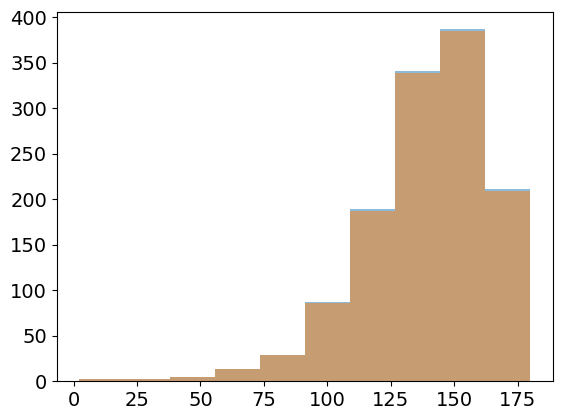

In [8]:
plt.hist(180-np.array(path_angles), alpha=.5)
plt.hist(nm.get('segment_meander_angles', nm_neuron)/np.pi*180, alpha=.5)

In [9]:
T = nt_neuron
z = dict()

z['branch points'] = T.get_branchpoints().size

tips = T.get_tips()

z['tips'] = tips.size

z['stems'] = len(T.edges(1))

z['total length'] = np.sum(list(T.get_edge_attributes('path_length').values()))
# get all radii
radii = T.get_node_attributes('radius')
# delete the soma
radii.pop(T.get_root())
z['avg thickness'] = np.mean(list(radii.values()))

z['total surface'] = np.sum(list(T.get_surface().values()))

z['max branch order'] = np.max(list(T.get_branch_order().values()))

branch_angles = list(T.get_branch_angles().values())
z['max branch angle'] = np.max(branch_angles)
z['min branch angle'] = np.min(branch_angles)
z['mean branch angle'] = np.mean(branch_angles)


tortuosity = [e[2]['path_length'] / e[2]['euclidean_dist'] for e in R.edges(data=True)]

z['max log tortuosity'] = np.log(np.percentile(tortuosity,99.5))




In [10]:
df = pd.concat(
    [
        pd.DataFrame(z,    index=["NeuronTree"]),
        pd.DataFrame(x,    index=["NeuronTree \n (no soma)"]),
        pd.DataFrame(z_nm, index=["NeuroM"]),
    ],
    axis=0,
    ignore_index=False,
    sort=False,
)

In [11]:
df.T

,NeuronTree,NeuronTree \n (no soma),NeuroM
branch points,35.000000,34.000000,34.000000
tips,45.000000,45.000000,43.000000
stems,11.000000,11.000000,9.000000
total length,7123.449510,7036.522849,7036.522461
avg thickness,0.212922,0.212922,0.204238
total surface,11049.200159,8524.099605,8524.100586
max branch order,9.000000,8.000000,8.000000
max branch angle,137.290397,137.290397,137.290336
min branch angle,8.634836,8.634836,8.634840
mean branch angle,73.760638,73.760638,73.760637


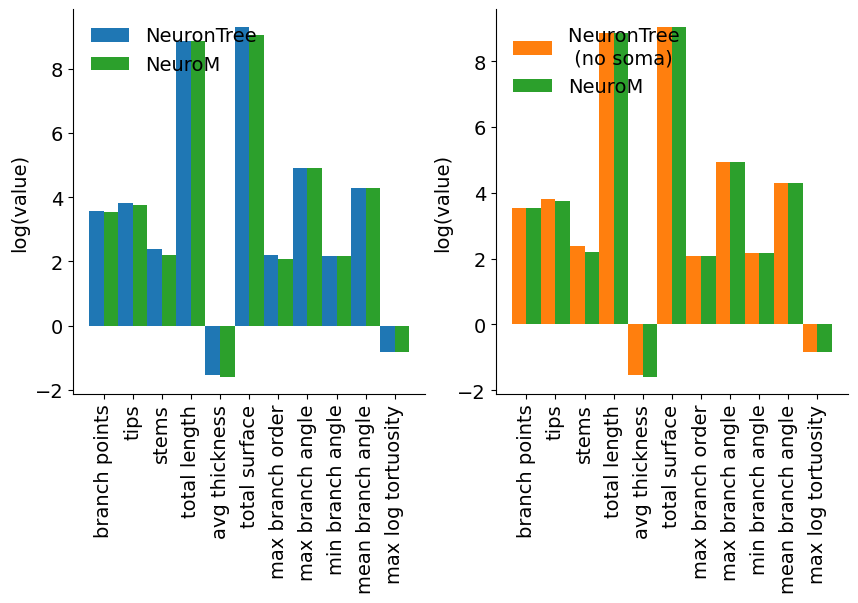

In [12]:
n = df.shape[1]
xses = np.vstack((np.arange(0.5, n + 0.5, 1), np.arange(1, n + 1, 1)))
tick_pos = 0.75 + np.arange(n)

colors = sns.color_palette()
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.bar(xses[0, :], np.log(df.iloc[0].values), label=df.iloc[0].name, color=colors[0], width=.5)
plt.bar(xses[1, :], np.log(df.iloc[2].values), label=df.iloc[2].name, color=colors[2], width=.5)
sns.despine()
plt.ylabel('log(value)')
plt.gca().set_xticks(tick_pos)
plt.gca().set_xticklabels(df.columns, rotation=90)
plt.legend(frameon=False, loc=2)

plt.subplot(122)
plt.bar(xses[0, :], np.log(df.iloc[1].values), label=df.iloc[1].name, color=colors[1], width=.5)
plt.bar(xses[1, :], np.log(df.iloc[2].values), label=df.iloc[2].name, color=colors[2], width=.5)
sns.despine()
plt.ylabel('log(value)')
plt.gca().set_xticks(tick_pos)
plt.gca().set_xticklabels(df.columns, rotation=90)
plt.legend(frameon=False, loc=2)

In [14]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-09-25 14:15:27CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.5.0

morphopy  : 0.7.3
pandas    : 2.3.2
numpy     : 2.3.3
seaborn   : 0.13.2
neurom    : 2.3.1
matplotlib: 3.10.6

Watermark: 2.5.0

